# Understanding Over & Underfitting
## Predicting Boston Housing Prices

## Getting Started
In this project, you will use the Boston Housing Prices dataset to build several models to predict the prices of homes with particular qualities from the suburbs of Boston, MA.
We will build models with several different parameters, which will change the goodness of fit for each. 

---
## Data Exploration
Since we want to predict the value of houses, the **target variable**, `'MEDV'`, will be the variable we seek to predict.

### Import and explore the data. Clean the data for outliers and missing values. 

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

In [9]:
df = pd.read_csv("boston_data.csv")

In [10]:
df.isna().sum()

crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
black      0
lstat      0
medv       0
dtype: int64

In [11]:
df.sample(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
359,0.01951,17.5,1.38,0.0,0.4161,7.104,59.5,9.2229,3.0,216.0,18.6,393.24,8.05,33.0
152,5.82401,0.0,18.10,0.0,0.5320,6.242,64.7,3.4242,24.0,666.0,20.2,396.90,10.74,23.0
56,0.22188,20.0,6.96,1.0,0.4640,7.691,51.8,4.3665,3.0,223.0,18.6,390.77,6.58,35.2
118,0.16760,0.0,7.38,0.0,0.4930,6.426,52.3,4.5404,5.0,287.0,19.6,396.90,7.20,23.8
374,7.36711,0.0,18.10,0.0,0.6790,6.193,78.1,1.9356,24.0,666.0,20.2,96.73,21.52,11.0
402,0.02055,85.0,0.74,0.0,0.4100,6.383,35.7,9.1876,2.0,313.0,17.3,396.90,5.77,24.7
174,0.06263,0.0,11.93,0.0,0.5730,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
109,0.02985,0.0,2.18,0.0,0.4580,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
73,0.12802,0.0,8.56,0.0,0.5200,6.474,97.1,2.4329,5.0,384.0,20.9,395.24,12.27,19.8
160,0.02009,95.0,2.68,0.0,0.4161,8.034,31.9,5.1180,4.0,224.0,14.7,390.55,2.88,50.0


In [12]:
#outliers
initial = np.abs(stats.zscore(df))
df = df[(initial < 3).all(axis=1)]
print(f"Initial size was {initial.shape}, after eliminating outliers is {df.shape}")

Initial size was (404, 14), after eliminating outliers is (321, 14)


### Next, we want to explore the data. Pick several varibables you think will be ost correlated with the prices of homes in Boston, and create plots that show the data dispersion as well as the regression line of best fit.

<AxesSubplot:>

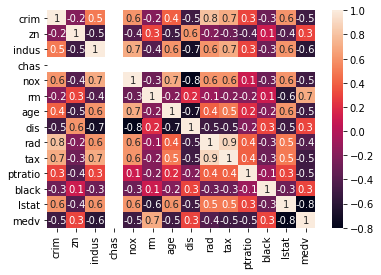

In [13]:
corr = round(df.corr(),1)
sns.heatmap(corr, annot=True)

### What do these plots tell you about the relationships between these variables and the prices of homes in Boston? Are these the relationships you expected to see in these variables?

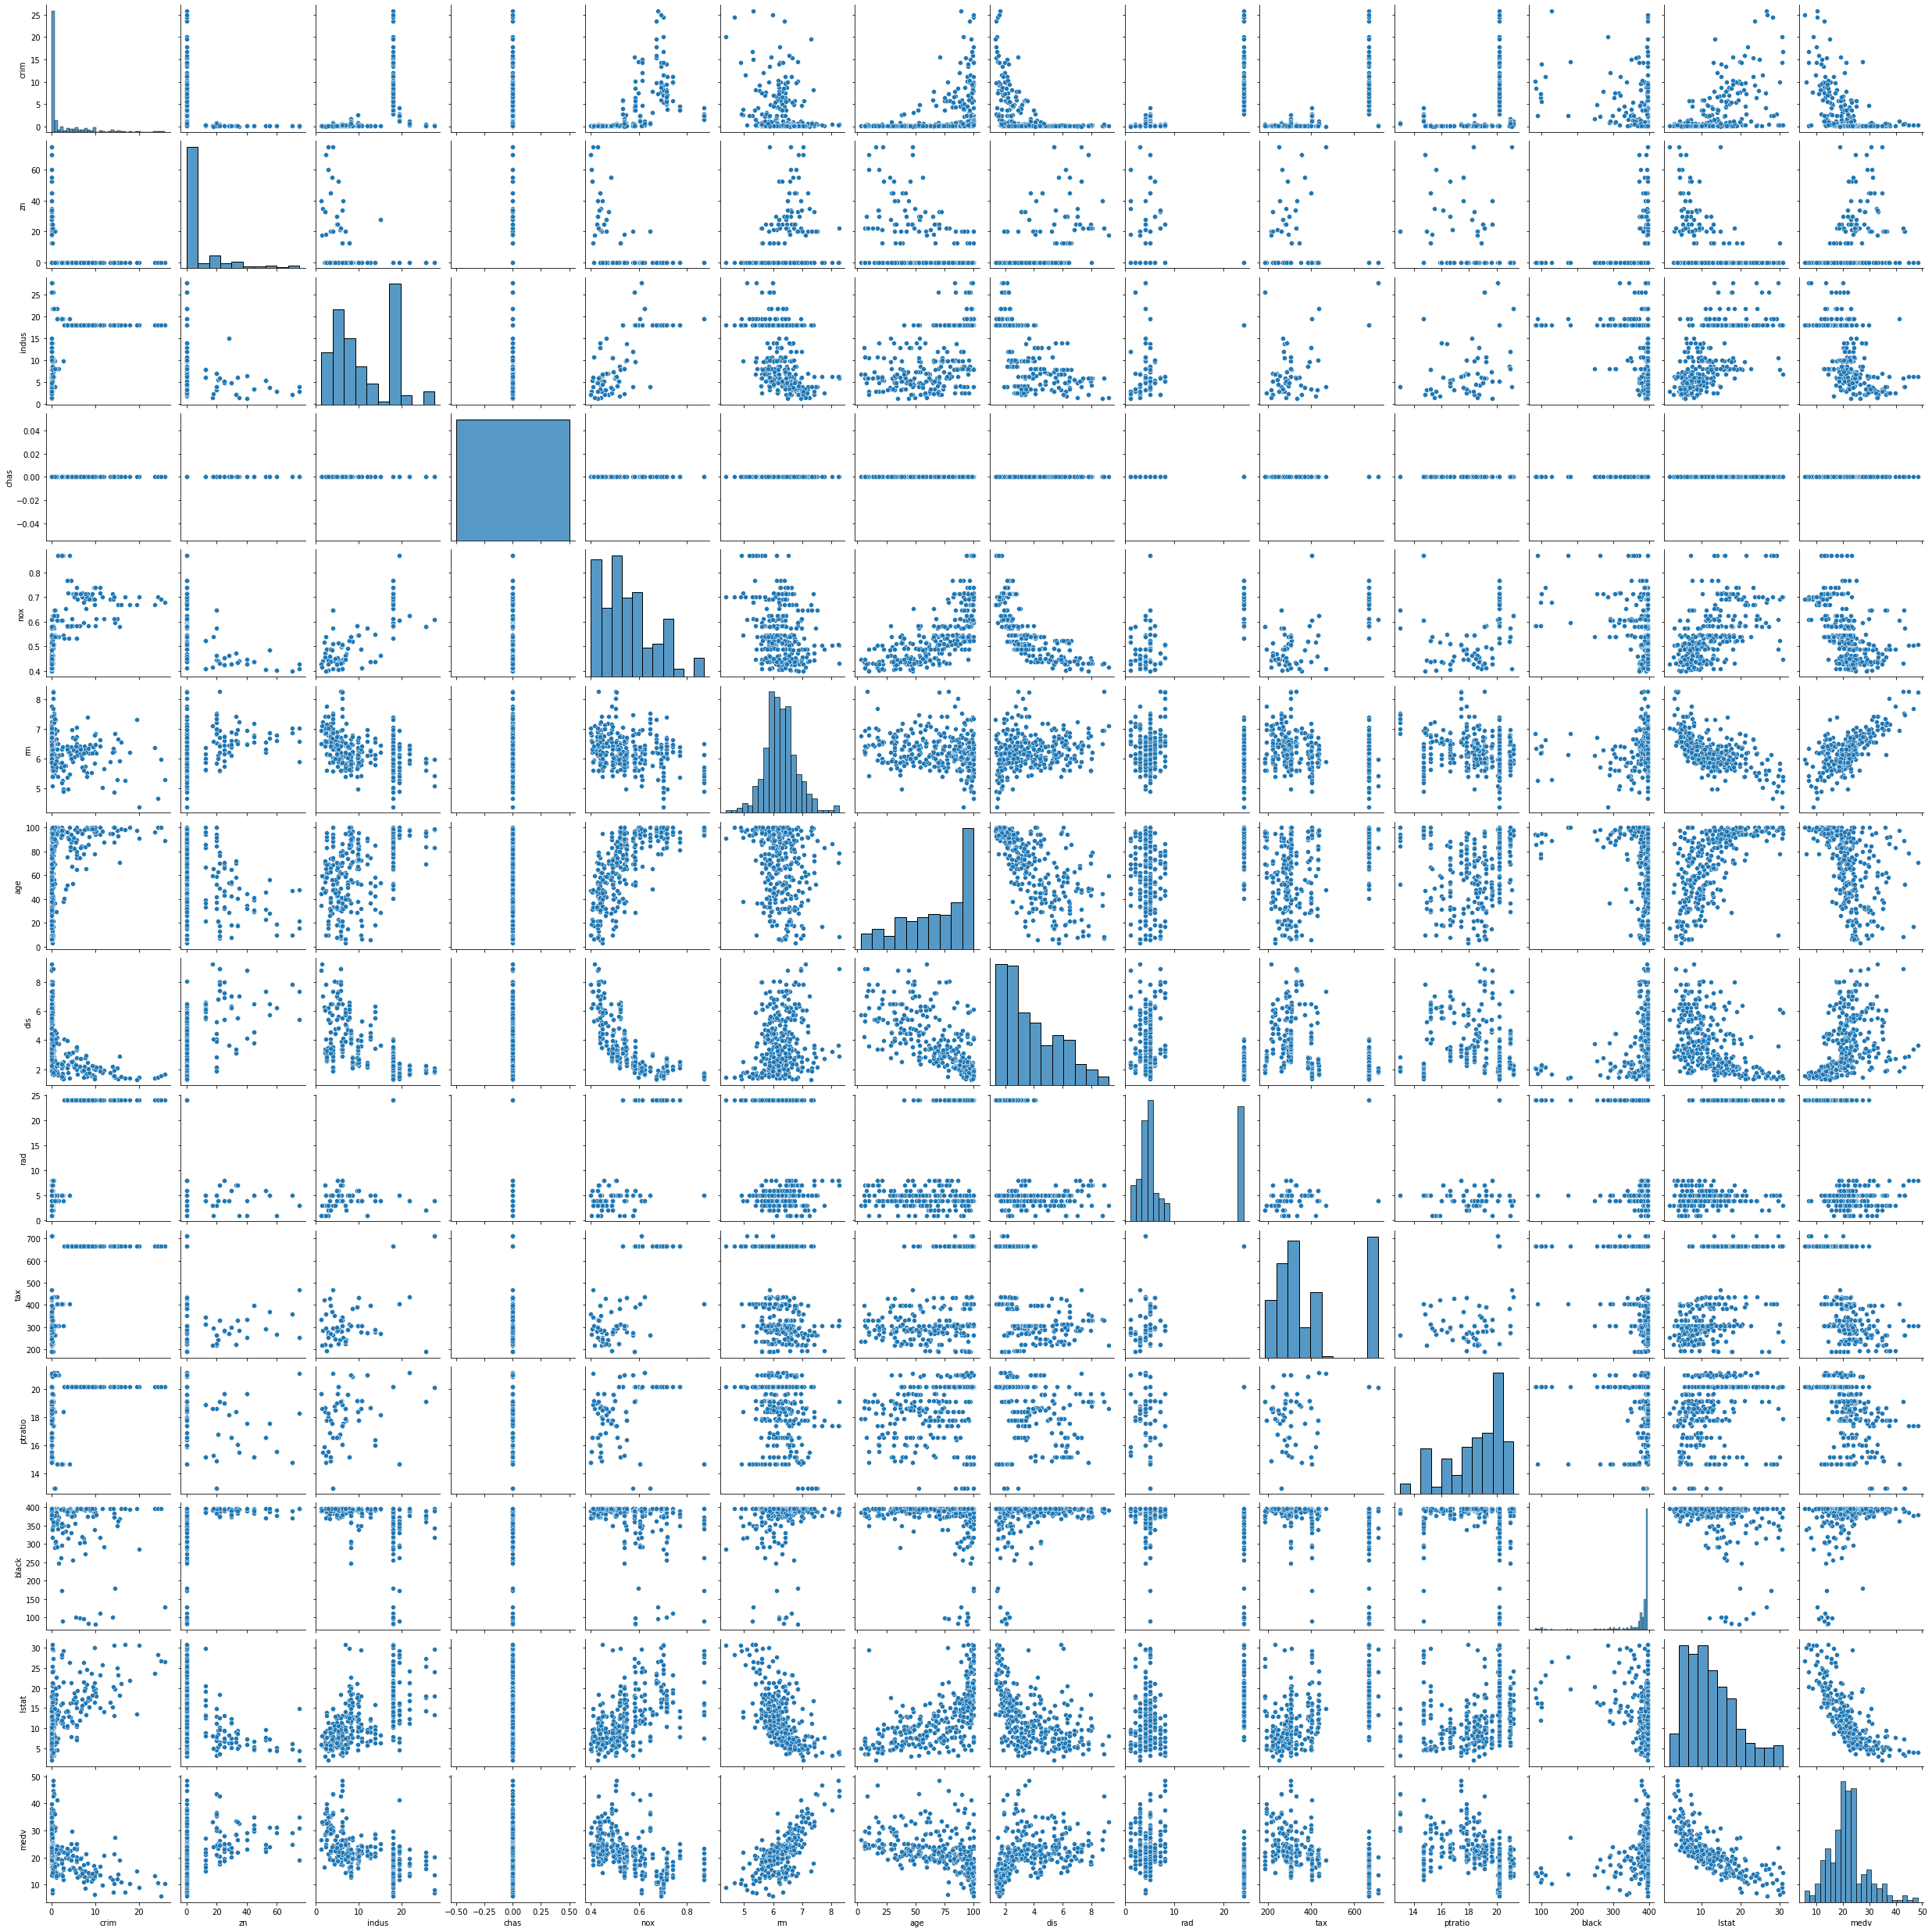

In [16]:
# Some variables appear decently correlated, both ways.
sns.pairplot(df)

### Make a heatmap of the remaining variables. Are there any variables that you did not consider that have very high correlations? What are they?

<AxesSubplot:>

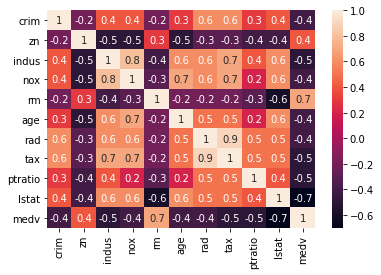

In [43]:
# dropping columns first
df1 = df.drop(["chas", "dis", "black"], axis=1)
corr = round(df1.corr(),1)
sns.heatmap(corr, annot=True)

### Calculate Statistics
Calculate descriptive statistics for housing price. Include the minimum, maximum, mean, median, and standard deviation. 

In [32]:
# My best attempt
#print(f"Min \n{round(df.min(),1)}\nMax \n{round(df.max(),1)}\nMean \n{round(df.mean(),1)}\nMed \n{round(df.median(),1)}Std \n{round(df.std(),1)}")
round(df.describe(),2)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
count,321.00,321.00,321.00,321.0,321.00,321.00,321.00,321.00,321.00,321.00,321.00,321.00,321.00,321.00
mean,2.53,7.37,11.03,0.0,0.55,6.26,68.16,3.80,9.12,398.53,18.55,373.20,12.56,21.78
std,4.74,15.40,6.68,0.0,0.11,0.57,27.89,1.90,8.41,165.99,2.04,55.71,6.48,7.12
min,0.01,0.00,1.25,0.0,0.40,4.37,2.90,1.32,1.00,188.00,13.00,81.33,1.98,5.60
25%,0.08,0.00,5.32,0.0,0.45,5.89,46.70,2.20,4.00,281.00,17.40,378.25,7.51,17.80
50%,0.21,0.00,8.56,0.0,0.53,6.22,74.40,3.36,5.00,311.00,19.10,392.53,11.32,21.20
75%,2.45,0.00,18.10,0.0,0.61,6.56,94.30,5.29,8.00,469.00,20.20,396.90,16.35,24.60
max,25.94,75.00,27.74,0.0,0.87,8.27,100.00,9.22,24.00,711.00,21.20,396.90,30.81,48.30


----

## Developing a Model

### Implementation: Define a Performance Metric
What is the performance meteric with which you will determine the performance of your model? Create a function that calculates this performance metric, and then returns the score. 

In [26]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    return mean_squared_error(y_true, y_predict)

### Implementation: Shuffle and Split Data
Split the data into the testing and training datasets. Shuffle the data as well to remove any bias in selecting the traing and test. 

In [28]:
from sklearn.model_selection import train_test_split

x = df.drop(labels='medv', axis=1)
y = df['medv']

x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=0.25, random_state = 23)

----

## Analyzing Model Performance
Next, we are going to build a Random Forest Regressor, and test its performance with several different parameter settings.

### Learning Curves
Lets build the different models. Set the max_depth parameter to 2, 4, 6, 8, and 10 respectively. 

In [ ]:
# Five separate RFR here with the given max depths

Now, plot the score for each tree on the training set and on the testing set.

In [ ]:
# Produce a plot with the score for the testing and training for the different max depths

What do these results tell you about the effect of the depth of the trees on the performance of the model?

In [ ]:
# Your response here

### Bias-Variance Tradeoff
When the model is trained with a maximum depth of 1, does the model suffer from high bias or from high variance? How about when the model is trained with a maximum depth of 10? Check out this article before answering: https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229

In [ ]:
# Your response here

### Best-Guess Optimal Model
What is the max_depth parameter that you think would optimize the model? Run your model and explain its performance.

In [ ]:
# Your response here

### Applicability
*In a few sentences, discuss whether the constructed model should or should not be used in a real-world setting.*  
**Hint:** Some questions to answering:
- *How relevant today is data that was collected from 1978?*
- *Are the features present in the data sufficient to describe a home?*
- *Is the model robust enough to make consistent predictions?*
- *Would data collected in an urban city like Boston be applicable in a rural city?*

In [ ]:
# Your response here